## Length of Stay (LOS) prediction based on MIMIC-III Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

**Team 13:**
* Tithi Agrawal (tra5235@psu.edu)
* Sricharan Boddupalli (sricharanb@psu.edu)

**Course:** DAAN 570 – Deep Learning (Spring I, 2023)

### Problem Statement
* Predict Length of Stay (LOS) based on Clinical signs found in text and considering structured information such as Age, Gender and major ICD Diagnoses
    
    
    
* **Keywords:** Feed Forward Neural Network, Fully Convolutional Network, ICD Diagnosis, Regression, Gradient Boost 
	

### Data Collection
* Source(url): https://physionet.org/content/mimiciii/1.4/
* Short Description : MIMIC-III is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (including post-hospital discharge).
MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors: it is freely available to researchers worldwide; it encompasses a diverse and very large population of ICU patients; and it contains highly granular data, including vital signs, laboratory results, and medications.

* Keywords: Feed Forward Neural Network, Fully Convolutional Network, ICD Diagnosis, Regression, Gradient Boost

# Global Reusable Functions

In [ ]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#E698E6', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();

In [ ]:
#define metrics function for us to calculate everything at the same place
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def perf_metrics(y_test, y_pred, name):
  MSE = mean_squared_error(y_test, y_pred)
  print(name, "Mean Squared Error:", f'{MSE:.2f}')
  MAE = mean_absolute_error(y_test, y_pred)
  print(name, "Mean Absolute Error:", f'{MAE:.2f}')
  R2 = r2_score(y_test, y_pred)
  print(name, "R-Squared Value:", f'{R2:.2f}')
  A_R2 = 1 - ((1 - R2) * (n - 1)) / (n - p - 1)
  print(name, "Adjusted R-Squared Value:", f'{A_R2:.2f}','\n')

# Data Exploration and Feature Engineering

In [ ]:
#Import data drom datasets
# This data is loaded onto our Google Drives and we retrieve them from there.
#If you have your own directory, please feel free to change the file path here (and in the function call mimic_los_cleanup below in the Data Preprocessing Section)
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/MIMIC-III CSV Files/ADMISSIONS.csv')
df_pat = pd.read_csv('/content/drive/MyDrive/Deep Learning/MIMIC-III CSV Files/PATIENTS.csv')
df_diagcode = pd.read_csv('/content/drive/MyDrive/Deep Learning/MIMIC-III CSV Files/DIAGNOSES_ICD.csv') 
df_icu = pd.read_csv('/content/drive/MyDrive/Deep Learning/MIMIC-III CSV Files/ICUSTAYS.csv')

## Admissions Exploration

In [ ]:
#check unique Admission records and Patient Records
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


### Calculate Length of Stay (LOS)
This is done by calculating the time between the ADMIT_TIME (Admission Time) and DISCHTIME (Discharge Time)

In [ ]:
# Convert admission and discharge times to datatime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

There seem to be some LOS with negative values.

This may mean they had passed away before they officially got discharged from the ICU. 

We can go ahead and drop those datapoints.

In [ ]:
# Drop LOS < 0 
df = df[df['LOS'] > 0]

In [ ]:
#Check the metrics of LOS
df['LOS'].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

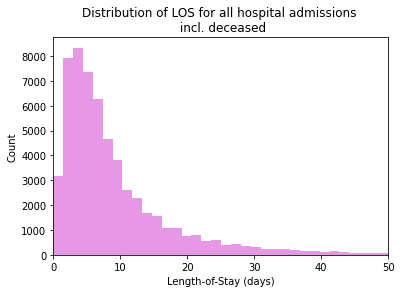

In [ ]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '#E698E6')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

We can drop some columns we don't need anymore.

In [ ]:
# Drop DISCHTIME, ROW_ID etc.
df.drop(columns=['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

### Death Time

Patients who have died in the hospital were seen to have a negative LOS as they were never discharged before they passed away.

So, we have to calculate their LOS till the time they passed away.

In [ ]:
# Mark admissions where patients died in boolean column
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

In [ ]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(),df['SUBJECT_ID'].nunique()))

5774 of 46445 patients died in the hospital


In [ ]:
# Look at statistics less admissions resulting in death
df['LOS'].loc[df['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

In [ ]:
# Hospital LOS metrics for later comparison
actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean() 
actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

10.138173704219813
6.565972222222222


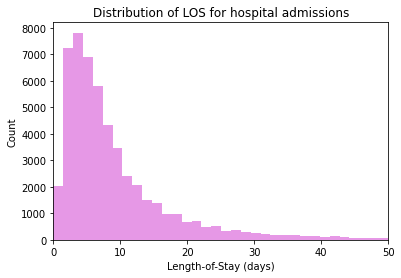

In [ ]:
plt.hist(df['LOS'].loc[df['DECEASED'] == 0], bins=200, color = '#E698E6')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

### Ethnicity 

Given the large amount of categories in the 'ETHNICITY' series, it helps to reduce the column to a few categories. 

Interestingly, Asians have the lowest median LOS. 

In [ ]:
df['ETHNICITY'].value_counts()

WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

In [ ]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


WHITE                     41268
OTHER/UNKNOWN              7700
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
Name: ETHNICITY, dtype: int64

### Religion

We thought it was interesting that this was tracked in MIMIC. 

BUDDHIST, HINDU, and MUSLIM trend with lower LOS medians, but are a very small proportion of the dataset. 

In [ ]:
df['RELIGION'].value_counts()

CATHOLIC                  20580
NOT SPECIFIED             11738
UNOBTAINABLE               8242
PROTESTANT QUAKER          7121
JEWISH                     5307
OTHER                      2695
EPISCOPALIAN                771
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

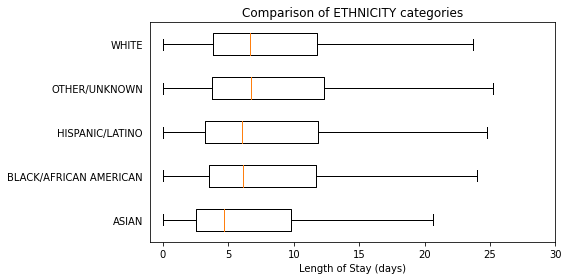

In [ ]:
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

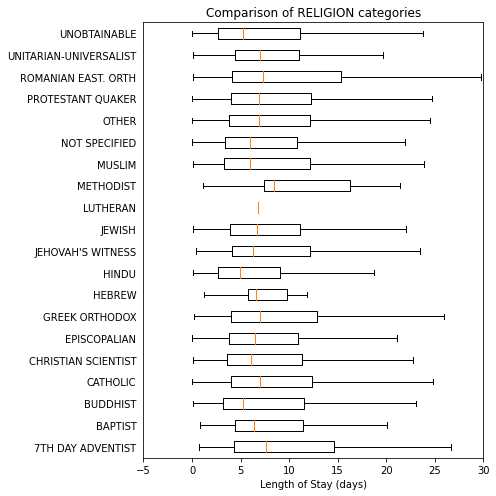

In [ ]:
boxplot_los_groupby('RELIGION', los_range=(-5, 30), size=(7, 7))

In [ ]:
# Reduce categories to terms of religious or not
# I tested with and without category reduction, with little change in R2 score
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())
print(df['RELIGION'].value_counts()[0]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[1]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[2]/len(df['RELIGION']))

RELIGIOUS        38898
NOT SPECIFIED    11738
UNOBTAINABLE      8242
Name: RELIGION, dtype: int64
0.6606542341791501
0.1993613913516084
0.13998437446924147


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


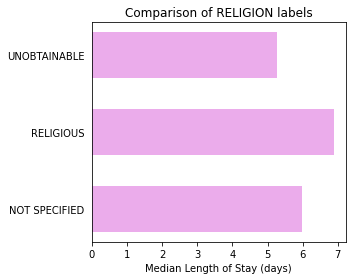

In [ ]:
# Look at median LOS for groups
plot_los_groupby('RELIGION', size=(5,4))

### Admission Type

Newborns have the lowest median LOS followed by elective admissions. This is expected since these are often somewhat planned for and with the risks being understood. 

In [ ]:
df['ADMISSION_TYPE'].value_counts()

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64

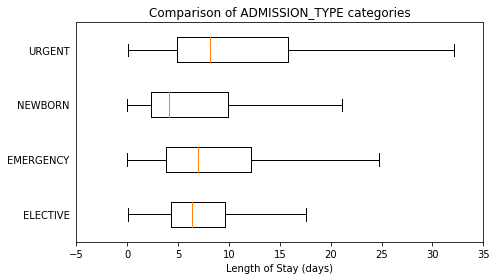

In [ ]:
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-5, 35), size=(7, 4))

### Insurance

If a patient is 'Self-Pay', typically means they can't or didn't pay. 

Self-pay patients may have the lowest LOS.  

In [ ]:
df['INSURANCE'].value_counts()

Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: INSURANCE, dtype: int64

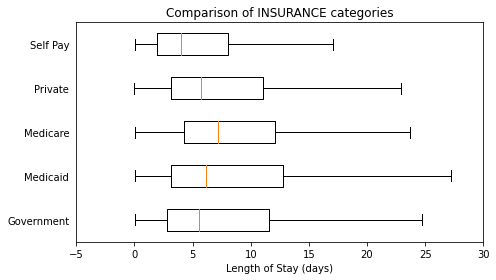

In [ ]:
boxplot_los_groupby('INSURANCE', los_range=(-5, 30), size=(7, 4))

### Marital status

In [ ]:
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
NaN                  10097
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [ ]:
# Fix NaNs and file under 'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

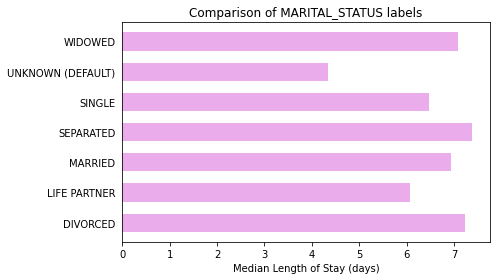

In [ ]:
plot_los_groupby('MARITAL_STATUS')

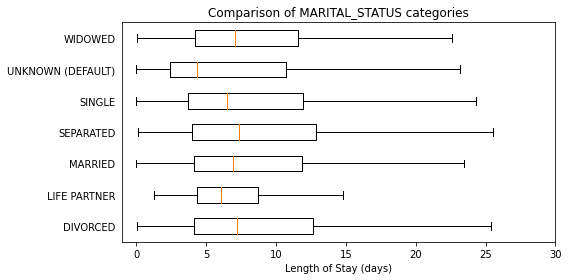

In [ ]:
boxplot_los_groupby('MARITAL_STATUS')

## Patients Exploration



The PATIENTS table provides age and gender information. 

To protect identity, a patient’s age is given by the difference between their 'DOB' date of birth and the date of their first admission. Therefore, subsequent admissions for the same patient need to be ignored in the calculation. 

The only things that need to be done with this table are to extract the DOB and gender information and merge them with the admissions dataframe. 

In [ ]:
df_pat.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


It is interesting that Python wa not able to calculate the years of the dat time objects properly (as it was giving out dates in the future).

This happens with all the date-time objects like Date of Birth, Date of Death etc.

In [ ]:
# Get the Genders captured in the dataset
df_pat['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [ ]:
# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [ ]:
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [ ]:
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

### Age

Now that the admissions dataFrame has DOB information, age can be calculated. 

We have to calculate Age at the time of admission.

In [ ]:
# Find the first admission time for each patient
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [ ]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [ ]:
# Verify merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,DECEASED,DOB,GENDER,ADMIT_MIN
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,0,2131-05-07,F,2196-04-09 12:26:00
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,0,2082-07-17,M,2153-09-03 07:15:00
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,MARRIED,WHITE,BRAIN MASS,6.768056,0,2082-07-17,M,2153-09-03 07:15:00
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,0,2100-05-31,M,2139-06-06 16:14:00
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,0,2101-11-21,M,2160-11-02 02:06:00


In [ ]:
# Age is decode by finding the difference in admission date and date of birth
df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN'])
df['ADMIT_MIN'] = df['ADMIT_MIN'].dt.date

df['DOB'] = pd.to_datetime(df['DOB'])
df['DOB'] = df['DOB'].dt.date

df['age'] = (df['ADMIT_MIN']-df['DOB']) //365
df['age'] = df['age'].dt.days

df['age'] = np.clip(df['age'], a_min=0, a_max=90)
df['age'].isnull().sum()

0

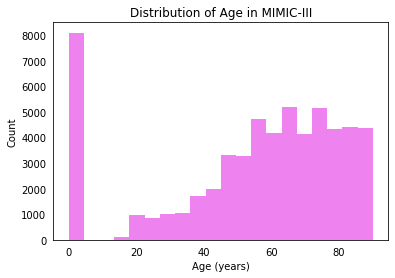

In [ ]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#EE82EE')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

(1.0, 50.0)

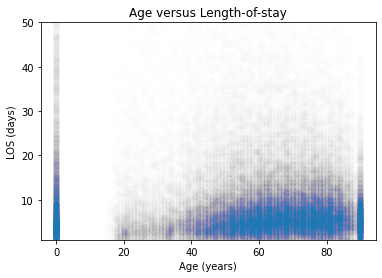

In [ ]:
plt.scatter(df['age'], df['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [ ]:
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), 
            num, df['age'])
    
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

senior          33785
middle_adult    12732
newborn          8101
young_adult      4260
Name: age, dtype: int64

### Gender

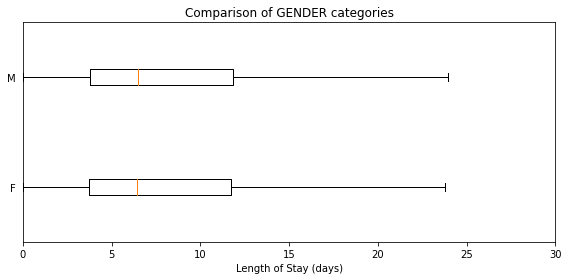

In [ ]:
boxplot_los_groupby('GENDER', los_range=(0, 30))
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

## ICU Stays Exploration

In [ ]:
# Intensive Care Unit (ICU) for each admission to hospital
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [ ]:
df_icu['HADM_ID'].nunique()

57786

In [ ]:
df_icu.groupby('FIRST_CAREUNIT').median()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
FIRST_CAREUNIT,,,,,,,
CCU,29091.5,22964.5,150074.5,249373.5,7.0,7.0,2.19775
CSRU,31002.5,24488.0,150225.0,250492.0,14.0,14.0,2.15290
MICU,33612.5,26489.5,150368.0,250524.0,50.0,50.0,2.09550
NICU,19581.5,15456.5,149206.5,249308.0,56.0,56.0,0.80250
SICU,38089.0,30084.0,149744.0,248649.0,33.0,33.0,2.25220
TSICU,36382.0,28716.0,148915.0,250685.0,14.0,14.0,2.11150


### ICU

In [ ]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [ ]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [ ]:
df_icu['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [ ]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

<ipython-input-53-4ccd019bc601>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)


,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [ ]:
print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

Number of admissions to ICU 49794.
Number of admissions to NICU 7992.


In [ ]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='HADM_ID')

In [ ]:
# Replace NaNs with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)

In [ ]:
# Verify NaN fix
print(df.ICU.value_counts(dropna=False))
print(df.NICU.value_counts(dropna=False))

1.0    49794
0.0     9168
Name: ICU, dtype: int64
0.0    50970
1.0     7992
Name: NICU, dtype: int64


<a class="anchor" id="Data-Preprocessing"></a>
# Data Preprocessing

In [ ]:
def mimic_los_cleanup(adm_csv, patients_csv,diagcode_csv, icu_csv,verbose=True):
    '''
    This function take 4 csv files from the MIMIC-III database, converts them to
    DataFrames for cleanup and feature engineering for use in a Length-of-Stay
    regression model such as the sklearn GradientBoostingRegressor. 
    
    INPUT:
    adm_csv - Primary Admissions information
    patients_csv - Patient specific info such as gender and DOB
    diagcode_csv - ICD9 Diagnosis for each admission to hospital
    icu_csv - Intensive Care Unit (ICU) data for each admission 
    
    OUTPUT:
    df - clean DataFrame for use in an regression model
    actual_median_los - Median LOS for all admissions 
    actual_mean_los - Average LOS for all admissions
    '''
    
    # Import CSV tables
    df = pd.read_csv(adm_csv)
    df_pat = pd.read_csv(patients_csv)
    df_diagcode = pd.read_csv(diagcode_csv)
    df_icu = pd.read_csv(icu_csv)
    if verbose: 
        print('(1/5) Completed .csv imports')
        
    # Feature Engineering for Length of Stay (LOS) target variable
    # Convert admission and discharge times to datatime type
    df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
    # Convert timedelta type into float 'days', 86400 seconds in a day
    df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400
    
    # Drop columns that are not needed for next steps
    df.drop(columns=['DISCHTIME', 'ROW_ID', 'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA'], inplace=True)
    
    # Track patients who died at the hospital by admission event
    df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})
    
    # Hospital LOS metrics
    actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean() 
    actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median() 
    
    # Compress the number of ethnicity categories
    df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
    df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
    df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
    df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
    df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
    df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'

    # Reduce categories to terms of religious or not
    df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

    # Re-categorize NaNs into 'Unknown'
    df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
    
    if verbose: 
        print('(2/5) Completed ADMISSIONS.csv cleanup and feature engineering.')
        
    # Feature Engineering for ICD9 code categories
    # Filter out E and V codes since processing will be done on the numeric first 3 values
    df_diagcode['recode'] = df_diagcode['ICD9_CODE']
    df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
    df_diagcode['recode'].fillna(value='999', inplace=True)
    df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
    df_diagcode['recode'] = df_diagcode['recode'].astype(int)
    
    # ICD-9 Main Category ranges
    icd9_ranges = [(1, 140), 
                   (140, 240), 
                   (240, 280), 
                   (280, 290), 
                   (290, 320), 
                   (320, 390), 
                   (390, 460), 
                   (460, 520), 
                   (520, 580), 
                   (580, 630), 
                   (630, 680), 
                   (680, 710),
                   (710, 740), 
                   (740, 760), 
                   (760, 780), 
                   (780, 800), 
                   (800, 1000), 
                   (1000, 2000)]

    # Associated category names
    diag_dict = {0: 'infectious', 
                 1: 'neoplasms', 
                 2: 'endocrine', 
                 3: 'blood',
                 4: 'mental', 
                 5: 'nervous', 
                 6: 'circulatory', 
                 7: 'respiratory',
                 8: 'digestive', 
                 9: 'genitourinary', 
                 10: 'pregnancy', 
                 11: 'skin', 
                 12: 'muscular', 
                 13: 'congenital', 
                 14: 'prenatal', 
                 15: 'misc',
                 16: 'injury', 
                 17: 'misc'}

    # Re-code in terms of integer
    for num, cat_range in enumerate(icd9_ranges):
        df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), num, df_diagcode['recode'])

    # Convert integer to category name using diag_dict
    df_diagcode['recode'] = df_diagcode['recode']
    df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)
    
    # Create list of diagnoses for each admission
    hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
    
    # Convert diagnoses list into hospital admission-item matrix
    hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
    
    # Join back with HADM_ID, will merge with main admissions DF later
    hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")

    # Merge with main admissions df
    df = df.merge(hadm_item, how='inner', on='HADM_ID')
    
    if verbose: 
        print('(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature engineering.')
    
    # Feature Engineering for Age and Gender
    # Convert to datetime type
    df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])
    df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
    df = df.merge(df_pat, how='inner', on='SUBJECT_ID')
    
    # Find the first admission time for each patient
    df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
    df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
    df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')
    
    # Age is decode by finding the difference in admission date and date of birth
    df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN'])
    df['ADMIT_MIN'] = df['ADMIT_MIN'].dt.date

    df['DOB'] = pd.to_datetime(df['DOB'])
    df['DOB'] = df['DOB'].dt.date

    df['age'] = (df['ADMIT_MIN']-df['DOB']) //365
    df['age'] = df['age'].dt.days

    df['age'] = np.clip(df['age'], a_min=0, a_max=90)
    
    # Create age categories
    age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
    for num, cat_range in enumerate(age_ranges):
        df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), num, df['age'])
    age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
    df['age'] = df['age'].replace(age_dict)
    
    # Re-map Gender to boolean type
    df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
    
    if verbose: 
        print('(4/5) Completed PATIENT.csv cleanup and feature engineering.')
    
    # Feature engineering for Intensive Care Unit (ICU) category
    # Reduce ICU categories to just ICU or NICU
    df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU','SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)
    df_icu['cat'] = df_icu['FIRST_CAREUNIT']
    icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
    icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
    icu_item[icu_item >= 1] = 1
    icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
    df = df.merge(icu_item, how='outer', on='HADM_ID')
    
    # Cleanup NaNs
    df['ICU'].fillna(value=0, inplace=True)
    df['NICU'].fillna(value=0, inplace=True)
    
    if verbose: 
        print('(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.')
        
    # Remove deceased persons as they will skew LOS result
    df = df[df['DECEASED'] == 0]

    # Remove LOS with negative number, likely entry form error
    df = df[df['LOS'] > 0]    
    
    # Drop unused columns, e.g. not used to predict LOS
    df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION','DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB', 'DIAGNOSIS', 'DECEASED', 'DEATHTIME'], inplace=True)
    
    prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR']
    dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION','ETHNICITY', 'age', 'MARITAL_STATUS']
    df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
    
    if verbose: 
        print('Data Preprocessing complete.')
    
    return df, actual_median_los, actual_mean_los

In [ ]:
df_clean, actual_median_los, actual_mean_los = mimic_los_cleanup(adm_csv = '/content/drive/MyDrive/Deep Learning/MIMIC-III CSV Files/ADMISSIONS.csv'
                                                                , patients_csv = '/content/drive/MyDrive/Deep Learning/MIMIC-III CSV Files/PATIENTS.csv', 
                                                                diagcode_csv = '/content/drive/MyDrive/Deep Learning/MIMIC-III CSV Files/DIAGNOSES_ICD.csv', 
                                                                 icu_csv = '/content/drive/MyDrive/Deep Learning/MIMIC-III CSV Files/ICUSTAYS.csv')

(1/5) Completed .csv imports


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(2/5) Completed ADMISSIONS.csv cleanup and feature engineering.


<ipython-input-3-9de783e2c4d0>:121: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)


(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature engineering.
(4/5) Completed PATIENT.csv cleanup and feature engineering.
(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.
Data Preprocessing complete.


<ipython-input-3-9de783e2c4d0>:173: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)


In [ ]:
# Verify output of cleaning function
df_clean.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58975
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         53104 non-null  float64
 1   blood                       53104 non-null  uint8  
 2   circulatory                 53104 non-null  uint8  
 3   congenital                  53104 non-null  uint8  
 4   digestive                   53104 non-null  uint8  
 5   endocrine                   53104 non-null  uint8  
 6   genitourinary               53104 non-null  uint8  
 7   infectious                  53104 non-null  uint8  
 8   injury                      53104 non-null  uint8  
 9   mental                      53104 non-null  uint8  
 10  misc                        53104 non-null  uint8  
 11  muscular                    53104 non-null  uint8  
 12  neoplasms                   53104 non-null  uint8  
 13  nervous                     531

In [ ]:
df_clean.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,AGE_newborn,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
0,1.144444,0,1,0,0,0,0,0,4,1,...,0,1,0,0,0,1,0,0,0,0
1,5.496528,0,4,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,6.768056,0,2,0,0,2,0,0,3,0,...,0,1,0,0,0,1,0,0,0,0
3,2.856944,0,2,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3.534028,0,3,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [ ]:
# Load the dataset
df = df_clean

# Split the dataset into training and testing sets
X = df.drop('LOS', axis=1)  # Features
y = df['LOS']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1289)

n = X_test.shape[0]      # number of samples in test set
p = X_test.shape[1]      # number of predictor variables

In [ ]:
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (42483, 48)
y_train shape: (42483,)
X_test shape: (10621, 48)
y_test shape: (10621,)


# Regression Models

We used 7 Machine Learning regression algorithms to guage the results of the Deep Learning Models.

In [ ]:
#Gradient Boosting regression
from sklearn.ensemble import GradientBoostingRegressor

# Train the model
gb1 = GradientBoostingRegressor()
gb1.fit(X_train, y_train)

# Make predictions on the test set
GB_y_pred = gb1.predict(X_test)

In [ ]:
#Linear regression
from sklearn.linear_model import LinearRegression

# Train the model
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

# Make predictions on the test set
LR_y_pred = lr1.predict(X_test)

In [ ]:
#Random Forest regression
from sklearn.ensemble import RandomForestRegressor

# Train the model
rf1 = RandomForestRegressor()
rf1.fit(X_train, y_train)

# Make predictions on the test set
RF_y_pred = rf1.predict(X_test)

In [ ]:
#XG Boost regression
from xgboost import XGBRegressor

# Train the model
xgb1 = XGBRegressor()
xgb1.fit(X_train, y_train)

# Make predictions on the test set
XGB_y_pred = xgb1.predict(X_test)

[23:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#Bagging regression
from sklearn.ensemble import BaggingRegressor

# Train the model
bagging1 = BaggingRegressor(n_estimators=100)
bagging1.fit(X_train, y_train)

# Make predictions on the test set
Bagging_y_pred = bagging1.predict(X_test)

In [ ]:
#Support Vector regression
from sklearn.svm import SVR

# Train the model with the radial kernel
sv1 = SVR(kernel='rbf')
sv1.fit(X_train, y_train)

# Make predictions on the test set
SV_y_pred = sv1.predict(X_test)

In [ ]:
#K-Neighbors regression
from sklearn.neighbors import KNeighborsRegressor

# Train the model
kn1 = KNeighborsRegressor(n_neighbors=5)
kn1.fit(X_train, y_train)

# Make predictions on the test set
KN_y_pred = kn1.predict(X_test)

In [ ]:
#Print all Regression Models' result metrics
perf_metrics(y_test=y_test, y_pred=GB_y_pred, name="Gradient Boosting Regressor")
perf_metrics(y_test=y_test, y_pred=LR_y_pred, name="Linear Regressor")
perf_metrics(y_test=y_test, y_pred=RF_y_pred, name="Random Forest Regressor")
perf_metrics(y_test=y_test, y_pred=XGB_y_pred, name="XGBoost Regressor")
perf_metrics(y_test=y_test, y_pred=Bagging_y_pred, name="Bagging Regressor")
perf_metrics(y_test=y_test, y_pred=SV_y_pred, name="Support Vector Regressor")
perf_metrics(y_test=y_test, y_pred=KN_y_pred, name="K Neighbors Regressor")

Gradient Boosting Regressor Mean Squared Error: 89.17
Gradient Boosting Regressor Mean Absolute Error: 5.50
Gradient Boosting Regressor R-Squared Value: 0.42
Gradient Boosting Regressor Adjusted R-Squared Value: 0.42 

Linear Regressor Mean Squared Error: 102.22
Linear Regressor Mean Absolute Error: 6.08
Linear Regressor R-Squared Value: 0.34
Linear Regressor Adjusted R-Squared Value: 0.33 

Random Forest Regressor Mean Squared Error: 95.30
Random Forest Regressor Mean Absolute Error: 5.68
Random Forest Regressor R-Squared Value: 0.38
Random Forest Regressor Adjusted R-Squared Value: 0.38 

XGBoost Regressor Mean Squared Error: 89.42
XGBoost Regressor Mean Absolute Error: 5.50
XGBoost Regressor R-Squared Value: 0.42
XGBoost Regressor Adjusted R-Squared Value: 0.42 

Bagging Regressor Mean Squared Error: 96.59
Bagging Regressor Mean Absolute Error: 5.69
Bagging Regressor R-Squared Value: 0.37
Bagging Regressor Adjusted R-Squared Value: 0.37 

Support Vector Regressor Mean Squared Error:

*The Gradient Boosting regression and the XGBoost regressor look good to predict the Length of Stay*

# Methodology

1. We have built 2 types of Neural Network Architectures.

2. The following are the 2 types of architectures we have used - 
 * Feed Forward Neural Network
    * A Feed Forward Neural Network is an artificial neural network in which the connections between nodes does not form a cycle. The feed forward model is the simplest form of neural network as information is only processed in one direction. While the data may pass through multiple hidden nodes, it always moves in one direction and never backwards.
 
 * Fully Convolutional Neural Network
    * A Fully Convolutional Neural Network (FCN) for 1-dimensional data is a type of neural network architecture that consists entirely of convolutional layers, without any fully connected layers. FCNs for 1D data are powerful models that can automatically learn features from raw signals, without the need for manual feature engineering.
 
3. Keywords: Feed Forward Neural Network, Fully Convolutional Network, ICD Diagnosis, Regression, Gradient Boost

4. Models were compiled and fit as inspired by the following github repositories - 
  * Feed Forward Neural Networks
    * MLH Repo - https://github.com/sdasara95/Machine-Learning-in-Healthcare
    * usama Repo - https://github.com/usama6679/LENGTH-OF-STAY-PREDICTION-AT-TIME-OF-AhhDMISSION
  * Fully Convolutional Neural Networks
    * NICU Repo - https://github.com/bt-s/NICU-length-of-stay-prediction

  These models will be further tuned with the helped of the Keras Tuner.

5. Model Evaluation
  * The models will be evaluated with the help of the following performance metrics - 
    * Mean Squared Error - This would help us in understanding the best models for minimizing the prediction errors
    * Mean Absolute Error - This would help us understand the best models with the smallest average deviation from the actual values
    * R-Squared Value - This will help us explain the largest proportion of variance in the data



# Feed Forward Neural Network

The Baseline Feed Forward Network was inspired from a Repository we found while doing our research for this project.

MLH Repo - https://github.com/sdasara95/Machine-Learning-in-Healthcare

Usama Repo - https://github.com/usama6679/LENGTH-OF-STAY-PREDICTION-AT-TIME-OF-AhhDMISSION

In [ ]:
#Import necessary libraries
import tensorflow as tf
import keras
from keras import backend
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras import Sequential
from keras.layers import Dense

In [ ]:
#create input_shape from X_train
cols = X_train.shape[1]
input_shape = (cols,)

In [ ]:
# Training the Feed Forward network
FFNN = models.Sequential()
FFNN.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape))
FFNN.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
FFNN.add(layers.Dropout(0.2))
FFNN.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
FFNN.add(layers.Dropout(0.2))
FFNN.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
FFNN.add(layers.Dropout(0.2))
FFNN.add(layers.Dense(1, activation='relu'))
print(FFNN.summary())

# FIT / TRAIN model on training daa

NumEpochs = 20
BatchSize = 8

# Compile the model and fit it on the training data
FFNN.compile(optimizer=optimizers.Adam(lr=1e-4), loss='mean_absolute_error', metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              50176     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#fit the model
history = FFNN.fit(X_train, y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(X_test, y_test))

Epoch 1/20
5311/5311 [==============================] - 27s 4ms/step - loss: 6.6387 - mae: 5.3176 - val_loss: 5.9890 - val_mae: 5.2965
Epoch 2/20
5311/5311 [==============================] - 22s 4ms/step - loss: 5.6568 - mae: 5.1764 - val_loss: 5.4838 - val_mae: 5.1466
Epoch 3/20
5311/5311 [==============================] - 23s 4ms/step - loss: 5.4084 - mae: 5.1374 - val_loss: 5.3891 - val_mae: 5.1700
Epoch 4/20
5311/5311 [==============================] - 25s 5ms/step - loss: 5.2818 - mae: 5.0883 - val_loss: 5.2714 - val_mae: 5.0984
Epoch 5/20
5311/5311 [==============================] - 23s 4ms/step - loss: 5.2216 - mae: 5.0620 - val_loss: 5.2561 - val_mae: 5.1097
Epoch 6/20
5311/5311 [==============================] - 23s 4ms/step - loss: 5.1823 - mae: 5.0409 - val_loss: 5.1964 - val_mae: 5.0610
Epoch 7/20
5311/5311 [==============================] - 24s 4ms/step - loss: 5.1448 - mae: 5.0145 - val_loss: 5.1946 - val_mae: 5.0688
Epoch 8/20
5311/5311 [==============================] -

In [ ]:
# Predicting on the test dataset
results = FFNN.evaluate(X_test, y_test)
print("_"*100)
print("Test Loss and MAE")
print("results ", results)

332/332 [==============================] - 1s 3ms/step - loss: 5.3342 - mae: 5.1937
____________________________________________________________________________________________________
Test Loss and MAE
results  [5.334236145019531, 5.193658351898193]


In [ ]:
y_pred = FFNN.predict(X_test)

332/332 [==============================] - 1s 2ms/step


In [ ]:
#get performance metrics (for verification)
perf_metrics(y_test, y_pred, "Feed Forward Network")

Feed Forward Network Mean Squared Error: 95.36
Feed Forward Network Mean Absolute Error: 5.19
Feed Forward Network R-Squared Value: 0.38
Feed Forward Network Adjusted R-Squared Value: 0.38 



In [ ]:
!pip install -q -U keras-tuner

import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners.hyperband import Hyperband
from keras.layers import Input, Dropout
from keras.callbacks import EarlyStopping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.0 MB/s eta 0:00:00


In [ ]:
def build_FF_model(hp):
    model = keras.Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=256, max_value=1024, step=256),
                           activation=hp.Choice('activation_1', ['relu', 'sigmoid', 'softmax', 'swish']), 
                           kernel_regularizer=regularizers.l2(0.001), 
                           input_shape=input_shape))
    model.add(Dense(units=hp.Int('units_2', min_value=256, max_value=1024, step=256),
                           activation=hp.Choice('activation_2', ['relu', 'sigmoid', 'softmax', 'swish']), 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(units=hp.Int('units_3', min_value=256, max_value=1024, step=256),
                           activation=hp.Choice('activation_3', ['relu', 'sigmoid', 'softmax', 'swish']), 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(units=hp.Int('units_4', min_value=256, max_value=1024, step=256),
                           activation=hp.Choice('activation_4', ['relu', 'sigmoid', 'softmax', 'swish']), 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizers.Adam(lr=1e-4),
                  loss='mean_absolute_error',
                  metrics=['mae'])
    return model

FF_tuner = kt.Hyperband(build_FF_model,
                     objective='val_mae',
                     max_epochs=20,
                     factor=3)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

FF_tuner.search(X_train, y_train, validation_data=(X_test, y_test), callbacks=[stop_early], epochs=20, batch_size=8)

best_hyperparameters = FF_tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
FF_tuner.results_summary(num_trials=10)

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 512
activation_1: relu
units_2: 768
activation_2: swish
units_3: 1024
activation_3: sigmoid
units_4: 512
activation_4: swish
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 5.097636699676514
Trial summary
Hyperparameters:
units_1: 512
activation_1: swish
units_2: 1024
activation_2: relu
units_3: 1024
activation_3: swish
units_4: 768
activation_4: relu
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 5.1026291847229
Trial summary
Hyperparameters:
units_1: 256
activation_1: relu
units_2: 512
activation_2: sigmoid
units_3: 768
activation_3: relu
units_4: 512
activation_4: swish
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 5.10593843460083
Trial summary
Hyperparameters:
units_1: 512
activation_1: relu
units_2: 768
activation_2:

In [ ]:
print(FF_tuner.get_best_hyperparameters()[0])

In [ ]:
best_hps = FF_tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
final_FF_model = build_FF_model(best_hps)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = final_FF_model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,batch_size=32)

Epoch 1/20
1328/1328 [==============================] - 6s 4ms/step - loss: 6.9860 - mae: 5.5211 - val_loss: 6.4419 - val_mae: 5.3810
Epoch 2/20
1328/1328 [==============================] - 6s 5ms/step - loss: 6.1805 - mae: 5.2955 - val_loss: 6.0363 - val_mae: 5.2887
Epoch 3/20
1328/1328 [==============================] - 5s 4ms/step - loss: 5.8869 - mae: 5.2294 - val_loss: 5.8699 - val_mae: 5.2912
Epoch 4/20
1328/1328 [==============================] - 7s 5ms/step - loss: 5.7080 - mae: 5.1865 - val_loss: 5.6654 - val_mae: 5.1958
Epoch 5/20
1328/1328 [==============================] - 5s 4ms/step - loss: 5.6015 - mae: 5.1706 - val_loss: 5.5722 - val_mae: 5.1732
Epoch 6/20
1328/1328 [==============================] - 6s 5ms/step - loss: 5.5170 - mae: 5.1458 - val_loss: 5.5210 - val_mae: 5.1695
Epoch 7/20
1328/1328 [==============================] - 6s 4ms/step - loss: 5.4667 - mae: 5.1357 - val_loss: 5.5108 - val_mae: 5.1968
Epoch 8/20
1328/1328 [==============================] - 5s 4ms

In [ ]:
y_pred = final_FF_model.predict(X_test)

332/332 [==============================] - 2s 4ms/step


In [ ]:
perf_metrics(y_test, y_pred, "Tuned Feed Forward Network")

Tuned Feed Forward Network Mean Squared Error: 98.42
Tuned Feed Forward Network Mean Absolute Error: 5.11
Tuned Feed Forward Network R-Squared Value: 0.36
Tuned Feed Forward Network Adjusted R-Squared Value: 0.36 



# Fully Convolutional Neural Network

In [ ]:
#create shape for the model input
input_shape = (X_train.shape[1],1)
input_shape

(48, 1)

In [ ]:
#import necessary libraries
import tensorflow as tf
import keras
from keras import backend
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam

In [ ]:
#build the Convolutional Model
FCN = Sequential()

#block1
FCN.add(Conv1D(128, 2, activation="relu", input_shape = input_shape))
BatchNormalization()
Dropout(0.4) 
 
#block2
FCN.add(Conv1D(256, 2, activation="relu"))
BatchNormalization()
Dropout(0.4)

#block3
FCN.add(Conv1D(256, 2, activation="relu"))
BatchNormalization()
Dropout(0.4)

#block4
FCN.add(Conv1D(128, 2, activation="relu"))
BatchNormalization()

#global average pooling
FCN.add(MaxPooling1D())
FCN.add(Flatten())
FCN.add(Dense(1,activation = "relu"))

FCN.compile(optimizer=optimizers.Adam(lr=0.001), loss='mean_squared_logarithmic_error', metrics=['mae'])
FCN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 47, 128)           384       
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 256)           65792     
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 256)           131328    
                                                                 
 conv1d_3 (Conv1D)           (None, 44, 128)           65664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2816)              0         
                                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#fit/train the model
NumEpochs = 20
BatchSize = 64

history = FCN.fit(X_train, y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(X_test, y_test))

Epoch 1/20
664/664 [==============================] - 11s 7ms/step - loss: 0.4378 - mae: 5.6140 - val_loss: 0.3900 - val_mae: 5.4803
Epoch 2/20
664/664 [==============================] - 4s 6ms/step - loss: 0.3833 - mae: 5.3774 - val_loss: 0.4158 - val_mae: 5.5360
Epoch 3/20
664/664 [==============================] - 5s 7ms/step - loss: 0.3755 - mae: 5.2927 - val_loss: 0.3764 - val_mae: 5.3040
Epoch 4/20
664/664 [==============================] - 5s 7ms/step - loss: 0.3711 - mae: 5.2561 - val_loss: 0.3771 - val_mae: 5.3529
Epoch 5/20
664/664 [==============================] - 7s 11ms/step - loss: 0.3706 - mae: 5.2508 - val_loss: 0.3718 - val_mae: 5.2724
Epoch 6/20
664/664 [==============================] - 4s 6ms/step - loss: 0.3682 - mae: 5.2278 - val_loss: 0.3695 - val_mae: 5.2481
Epoch 7/20
664/664 [==============================] - 4s 6ms/step - loss: 0.3665 - mae: 5.2121 - val_loss: 0.3708 - val_mae: 5.2495
Epoch 8/20
664/664 [==============================] - 4s 6ms/step - loss: 

In [ ]:
# Predicting on the test dataset
results = FCN.evaluate(X_test, y_test)
print("_"*100)
print("Test Loss and MAE")
print("results ", results)

332/332 [==============================] - 2s 4ms/step - loss: 0.3678 - mae: 5.2040
____________________________________________________________________________________________________
Test Loss and MAE
results  [0.36776188015937805, 5.203963756561279]


In [ ]:
y_pred = FCN.predict(X_test)

332/332 [==============================] - 1s 2ms/step


In [ ]:
#get performance metrics (for verification)
perf_metrics(y_test, y_pred, "Fully Convolutional Network")

Fully Convolutional Network Mean Squared Error: 94.81
Fully Convolutional Network Mean Absolute Error: 5.20
Fully Convolutional Network R-Squared Value: 0.38
Fully Convolutional Network Adjusted R-Squared Value: 0.38 



In [ ]:
!pip install -q -U keras-tuner

import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners.hyperband import Hyperband
from keras.layers import Input, Dropout
from keras.callbacks import EarlyStopping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.2 MB/s eta 0:00:00


In [ ]:
def build_FCN_model(hp):
    model = Sequential()
    model.add(Conv1D(hp.Int('units_1', min_value=256, max_value=1024, step=256),
                     2,
                     activation=hp.Choice('activation_1', ['relu', 'sigmoid', 'softmax', 'swish']),  
                     input_shape=input_shape))
    BatchNormalization()
    Dropout(0.4)
    model.add(Conv1D(hp.Int('units_2', min_value=256, max_value=1024, step=256),
                     2,
                     activation=hp.Choice('activation_2', ['relu', 'sigmoid', 'softmax', 'swish']),  
                     input_shape=input_shape))
    BatchNormalization()
    Dropout(0.4)
    model.add(Conv1D(hp.Int('units_3', min_value=256, max_value=1024, step=256),
                     2,
                     activation=hp.Choice('activation_3', ['relu', 'sigmoid', 'softmax', 'swish']),  
                     input_shape=input_shape))
    BatchNormalization()
    Dropout(0.4)
    model.add(Conv1D(hp.Int('units_4', min_value=256, max_value=1024, step=256),
                     2,
                     activation=hp.Choice('activation_4', ['relu', 'sigmoid', 'softmax', 'swish']),  
                     input_shape=input_shape))
    BatchNormalization()
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(1,activation = hp.Choice('activation_5', ['relu', 'sigmoid', 'softmax', 'swish'])))
    model.compile(optimizer=optimizers.Adam(lr=1e-4),
                  loss='mean_squared_logarithmic_error',
                  metrics=['mae'])
    return model

FCN_tuner = kt.Hyperband(build_FCN_model,
                     objective='val_mae',
                     max_epochs=20,
                     factor=3,
                     directory="FCN")

stop_early = EarlyStopping(monitor='val_loss', patience=5)

FCN_tuner.search(X_train, y_train, validation_data=(X_test, y_test), callbacks=[stop_early], epochs=20, batch_size=8)

best_hyperparameters = FCN_tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 28 Complete [00h 04m 48s]
val_mae: 9.228848457336426

Best val_mae So Far: 5.180224418640137
Total elapsed time: 01h 37m 39s

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
1024              |512               |units_1
sigmoid           |relu              |activation_1
1024              |1024              |units_2
swish             |sigmoid           |activation_2
512               |768               |units_3
swish             |relu              |activation_3
1024              |1024              |units_4
swish             |relu              |activation_4
swish             |relu              |activation_5
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5311/5311 [==============================] - 50s 9ms/step - loss: 0.4256 - mae: 5.6000 - val_loss: 0.3971 - val_mae: 5.4581
Epoch 2/20
5311/5311 [==============================] - 47s 9ms/step - loss: 0.3848 - mae: 5.3478 - val_loss: 0.3925 - val_mae: 5.4558
Epoch 3/20
5311/5311 [==============================] - 53s 10ms/step - loss: 0.3806 - mae: 5.3208 - val_loss: 0.3785 - val_mae: 5.3519
Epoch 4/20
5311/5311 [==============================] - 48s 9ms/step - loss: 0.3781 - mae: 5.3066 - val_loss: 0.3806 - val_mae: 5.3308
Epoch 5/20
5311/5311 [==============================] - 49s 9ms/step - loss: 0.3758 - mae: 5.2920 - val_loss: 0.3812 - val_mae: 5.3503
Epoch 6/20
5311/5311 [==============================] - 48s 9ms/step - loss: 0.3750 - mae: 5.2894 - val_loss: 0.3755 - val_mae: 5.3393
Epoch 7/20
5311/5311 [==============================] - 47s 9ms/step - loss: 0.3733 - mae: 5.2753 - val_loss: 0.3750 - val_mae: 5.3092
Epoch 8/20
5311/5311 [==============================] - 48s 9ms/s

In [ ]:
FCN_tuner.results_summary(num_trials=10)

Results summary
Results in FCN/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 512
activation_1: relu
units_2: 1024
activation_2: sigmoid
units_3: 768
activation_3: relu
units_4: 1024
activation_4: relu
activation_5: relu
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 5.180224418640137
Trial summary
Hyperparameters:
units_1: 512
activation_1: sigmoid
units_2: 512
activation_2: swish
units_3: 256
activation_3: relu
units_4: 1024
activation_4: sigmoid
activation_5: swish
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 5.2309441566467285
Trial summary
Hyperparameters:
units_1: 1024
activation_1: sigmoid
units_2: 1024
activation_2: swish
units_3: 512
activation_3: swish
units_4: 1024
activation_4: swish
activation_5: swish
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 5.253264427185059
Trial summary
Hyperparameters:
units_

In [ ]:
print(FCN_tuner.get_best_hyperparameters()[0])

In [ ]:
best_hps = FCN_tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
final_FCN_model = build_FCN_model(best_hps)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = final_FCN_model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,batch_size=32)

Epoch 1/20
1328/1328 [==============================] - 24s 17ms/step - loss: 0.4573 - mae: 5.7340 - val_loss: 0.3995 - val_mae: 5.5068
Epoch 2/20
1328/1328 [==============================] - 23s 17ms/step - loss: 0.3858 - mae: 5.3856 - val_loss: 0.3841 - val_mae: 5.4051
Epoch 3/20
1328/1328 [==============================] - 23s 17ms/step - loss: 0.3806 - mae: 5.3393 - val_loss: 0.3853 - val_mae: 5.4002
Epoch 4/20
1328/1328 [==============================] - 22s 17ms/step - loss: 0.3760 - mae: 5.3035 - val_loss: 0.3775 - val_mae: 5.3444
Epoch 5/20
1328/1328 [==============================] - 22s 17ms/step - loss: 0.3746 - mae: 5.2886 - val_loss: 0.3764 - val_mae: 5.3456
Epoch 6/20
1328/1328 [==============================] - 22s 17ms/step - loss: 0.3726 - mae: 5.2741 - val_loss: 0.3750 - val_mae: 5.3002
Epoch 7/20
1328/1328 [==============================] - 23s 17ms/step - loss: 0.3709 - mae: 5.2618 - val_loss: 0.3756 - val_mae: 5.3083
Epoch 8/20
1328/1328 [==========================

In [ ]:
y_pred = final_FCN_model.predict(X_test)

332/332 [==============================] - 2s 5ms/step


In [ ]:
perf_metrics(y_test, y_pred, "Tuned Fully Convolutinal Network")

Tuned Fully Convolutinal Network Mean Squared Error: 103.13
Tuned Fully Convolutinal Network Mean Absolute Error: 5.24
Tuned Fully Convolutinal Network R-Squared Value: 0.33
Tuned Fully Convolutinal Network Adjusted R-Squared Value: 0.33 



# Save best model weights
We have to save the Self Tunes Feed Forward Neural Network

In [ ]:
FFNN.save_weights('/content/drive/MyDrive/Deep Learning/LOSPredictionWeights/')

#  References
  - Johnson AEW, Pollard TJ, Shen L, Lehman LH, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, Mark RG. MIMIC-III, a freely accessible critical care database. Scientific data. 2016 May 24;3(1):1-9.
  - Hu, S., Teng, F., Huang, L., Yan, J., & Zhang, H. (2021). An explainable CNN approach for medical codes prediction from clinical text. BMC Medical Informatics and Decision Making, 21, 1-12
  - Straathof, B. T. (2020). A Deep Learning Approach to Predicting the Length of Stay of Newborns in the Neonatal Intensive Care Unit.
  - Gentimis, T., Ala’J, A., Durante, A., Cook, K., & Steele, R.: Predicting hospital length of stay using neural networks on mimic iii data. In 2017 IEEE 15th International Conference on Dependable, Autonomic and Secure Computing, 15th International Conference on Pervasive Intelligence and Computing, 3rd International Conference on Big Data Intelligence and Computing and Cyber Science and Technology Congress (DASC/PiCom/DataCom/CyberSciTech). (pp. 1194–1201). IEEE
  - Jana, S., Dasgupta, T., & Dey, L. (2022). Using nursing notes to predict length of stay in ICU for critically ill patient. In Multimodal AI in healthcare: A paradigm shift in health intelligence. Studies in computational intelligence. Springer.
  - Predicting hospital length-of-stay at time of admission - https://towardsdatascience.com/predicting-hospital-length-of-stay-at-time-of-admission-55dfdfe69598
	

# Credits

- This code is based on the following Github Repositories - 

1. TDS Repo - https://github.com/daniel-codes/hospital-los-predictor
2. NICU Repo - https://github.com/bt-s/NICU-length-of-stay-prediction
3. MLH Repo - https://github.com/sdasara95/Machine-Learning-in-Healthcare
4. RNN Repo - https://github.com/sudhan-bhattarai/MIMIC-III
5. Keras Repo - https://github.com/cothurn/LCU-LoS-Prediction-based-on-MIMIC-III-with-Keras
6. TPC Repo - https://github.com/EmmaRocheteau/TPC-LoS-prediction
7. Usama Repo - https://github.com/usama6679/LENGTH-OF-STAY-PREDICTION-AT-TIME-OF-AhhDMISSION
8. Alki Repo - https://github.com/alki284/LOS-Prediction
9. Chantal Repo - https://github.com/ChantalMP/Unsupervised-Pre-Training-on-Patient-Population-Graphs-for-Patient-Level-Predictions
